## Obligatorio Taller de tecnologías para Big Data - "MeteoSmart– Soluciones Meteorológicas Basadas en Big Data"

* Juan Assandri - 315622
* Oliver Kaminski - 338835
* Felipe Burgos - 208166

In [1]:
import subprocess
import sys

# Función para verificar e instalar librerías, esto permite verificar si las librerias estan instaladas previamente.
def install_package(package):
    try:
        __import__(package)
        print(f"{package} ya está instalado.")
    except ImportError:
        print(f"{package} no está instalado. Instalando...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Verificar e instalar las librerías necesarias
install_package('pandas')
install_package('matplotlib')
install_package('seaborn')


pandas ya está instalado.
matplotlib ya está instalado.
seaborn ya está instalado.


In [2]:
#Iniciamos Spark Session e instalamos las librerias necesarias

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MeteoSmart").config("spark.hadoop.hive.metastore.uris", "thrift://localhost:9083").enableHiveSupport().getOrCreate()

from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType, StringType, DoubleType, FloatType, LongType, DateType

from pyspark.sql import Window

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/05 18:16:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
#Leemos archivos desde carpeta lnd

alertas = spark.read.csv("/user/ec2-user/Obligatorio_315622_338835_208166/MeteoSmart/lnd/alertas.csv", header = True, sep=",", encoding="ISO-8859-1")
eventos = spark.read.csv("/user/ec2-user/Obligatorio_315622_338835_208166/MeteoSmart/lnd/eventos.csv", header = True, sep=",", encoding="ISO-8859-1")
usuarios = spark.read.csv("/user/ec2-user/Obligatorio_315622_338835_208166/MeteoSmart/lnd/usuarios.csv", header = True, sep=",", encoding="ISO-8859-1")
paises = spark.read.csv("/user/ec2-user/Obligatorio_315622_338835_208166/MeteoSmart/lnd/paises.csv", header = True, sep=",", encoding="ISO-8859-1")

## Analisis Exploratorio (EDA)


#### Definimos las funciones que vamos a utilizar para detectar valores Null asi como filas duplicadas. Para ello definiremos dos funciones, por un lado verificar duplicados de la fila integra, por otro verificaremos filas duplicadas sin considerar la PK, esto nos permitira verificar que no haya registros que no corresponen o vayan en contra de un modelo relacional.

In [4]:
def contar_valores_nulos(df):
    """
    Esta función toma un DataFrame de PySpark y devuelve un DataFrame
    con el conteo de los valores nulos (null) para cada columna.
    
    :param df: DataFrame de PySpark
    :return: DataFrame con el conteo de valores nulos o NaN por columna
    """
    # Contamos los valores nulos (null) para cada columna
    df.select(
        [count(when(isnull(c), c)).alias(c) for c in df.columns]
    ).show()


In [5]:
def encontrar_duplicados_sin_id(df, columnas_duplicadas, columna_id):
    """
    Encuentra duplicados en el DataFrame, ignorando la columna de ID.
    
    :param df: DataFrame de entrada.
    :param columnas_duplicadas: Lista de las columnas sobre las cuales identificar duplicados.
    :param columna_id: Nombre de la columna que es identificador único (PK), que no debe considerarse en la comparación.
    :return: DataFrame con las filas duplicadas y el conteo de repeticiones.
    """
    
    # Creamos la especificación de la ventana para agrupar por las columnas sin la columna de ID
    columnas_sin_id = [col for col in columnas_duplicadas if col != columna_id]
    window_spec = Window.partitionBy(*columnas_sin_id)
    
    # Contamos las ocurrencias de cada combinación de columnas
    df_conteo = df.withColumn("count", count("*").over(window_spec))
    
    # Filtramos solo las filas donde el conteo es mayor a 1 (duplicados)
    duplicados_con_id = df_conteo.filter(col("count") > 1).select(columna_id, *columnas_duplicadas, "count")
    
    # Mostrarmos los resultados
    duplicados_con_id.show(100, truncate=False)
    
    return duplicados_con_id

In [6]:
def show_duplicate_subset(df, subset=None):
    """
    Esta función identifica y muestra las filas duplicadas en un DataFrame de Spark, 
    basándose en un subconjunto de columnas especificado por el parámetro `subset`. 
    Si no se proporciona un subconjunto, se utilizarán todas las columnas del DataFrame para detectar duplicados.
    Utiliza una ventana de partición para contar la cantidad de ocurrencias de cada combinación de valores en las columnas seleccionadas. 
    Luego, filtra aquellas filas cuyo conteo es mayor a 1, indicando que son duplicadas. 
    """
    
    if subset is None:
        subset = df.columns

    window_spec = Window.partitionBy([col(c) for c in subset])

    flagged_df = df.withColumn("row_count", count("*").over(window_spec))

    duplicates_df = flagged_df.filter(col("row_count") > 1).drop("row_count")

    duplicates_df.show(100, truncate=False)

## Tabla Alertas


In [7]:
# Cuenta el número total de filas en el DataFrame.

alertas.count()

1000

In [8]:
# Muestra el esquema del DataFrame, incluyendo los nombres y tipos de datos de las columnas.
# PySpark por defecto infiere todo como string.

alertas.printSchema()

root
 |-- id_alerta_met: string (nullable = true)
 |-- tipo_alerta: string (nullable = true)
 |-- nivel_alerta: string (nullable = true)



In [9]:
# Cambiamos el tipo de dato de aquellos que consideramos.

alertas = alertas.withColumn(
    'id_alerta_met',
    col('id_alerta_met').cast(IntegerType())
)

In [10]:
# Muestra filas del DataFrame 'alertas', sin truncar el contenido de las columnas.

alertas.show(5, truncate=False)

+-------------+-----------+------------+
|id_alerta_met|tipo_alerta|nivel_alerta|
+-------------+-----------+------------+
|1            |Tornado    |Bajo        |
|2            |Tornado    |Moderado    |
|3            |Tornado    |Alto        |
|4            |Tornado    |Extremo     |
|5            |HuracÃ¡n   |Bajo        |
+-------------+-----------+------------+
only showing top 5 rows



In [11]:
# Verificamos el Schema a efectos de ver el cambio del tipo de dominio.
alertas.printSchema()

root
 |-- id_alerta_met: integer (nullable = true)
 |-- tipo_alerta: string (nullable = true)
 |-- nivel_alerta: string (nullable = true)



In [12]:
# Verificamos valores nulos de la tabla 'alertas' mediante las funciones predefinidas

contar_valores_nulos(alertas)

+-------------+-----------+------------+
|id_alerta_met|tipo_alerta|nivel_alerta|
+-------------+-----------+------------+
|            0|          0|           0|
+-------------+-----------+------------+



In [13]:
# Verificamos columnas duplicadas de la tabla 'alertas', seprando la columna de id del resto.
# Esto permite verificar si existen filas duplicadas sin el id, ya que el id puede ser diferente pero el resto no.
# Ademas se indentifica cuantas veces esta duplicada cada fila.

columnas_duplicadas = ["tipo_alerta", "nivel_alerta"]
columna_id = "id_alerta_met"

encontrar_duplicados_sin_id(alertas,columnas_duplicadas,columna_id)

+-------------+-----------------------+------------+-----+
|id_alerta_met|tipo_alerta            |nivel_alerta|count|
+-------------+-----------------------+------------+-----+
|27           |Alerta de calor extremo|Alto        |13   |
|107          |Alerta de calor extremo|Alto        |13   |
|187          |Alerta de calor extremo|Alto        |13   |
|267          |Alerta de calor extremo|Alto        |13   |
|347          |Alerta de calor extremo|Alto        |13   |
|427          |Alerta de calor extremo|Alto        |13   |
|507          |Alerta de calor extremo|Alto        |13   |
|587          |Alerta de calor extremo|Alto        |13   |
|667          |Alerta de calor extremo|Alto        |13   |
|747          |Alerta de calor extremo|Alto        |13   |
|827          |Alerta de calor extremo|Alto        |13   |
|907          |Alerta de calor extremo|Alto        |13   |
|987          |Alerta de calor extremo|Alto        |13   |
|25           |Alerta de calor extremo|Bajo        |13  

DataFrame[id_alerta_met: int, tipo_alerta: string, nivel_alerta: string, count: bigint]

In [14]:
# Verificamos columnas duplicadas de la tabla 'alertas', aqui se verifica toda la fila que puede incluir el id.
# En nuestro caso, por como se generarn los datos, decidimos verificar sin id, es similar a la anterior.

show_duplicate_subset(alertas, ["tipo_alerta", "nivel_alerta"])

+-------------+-----------------------+------------+
|id_alerta_met|tipo_alerta            |nivel_alerta|
+-------------+-----------------------+------------+
|27           |Alerta de calor extremo|Alto        |
|107          |Alerta de calor extremo|Alto        |
|187          |Alerta de calor extremo|Alto        |
|267          |Alerta de calor extremo|Alto        |
|347          |Alerta de calor extremo|Alto        |
|427          |Alerta de calor extremo|Alto        |
|507          |Alerta de calor extremo|Alto        |
|587          |Alerta de calor extremo|Alto        |
|667          |Alerta de calor extremo|Alto        |
|747          |Alerta de calor extremo|Alto        |
|827          |Alerta de calor extremo|Alto        |
|907          |Alerta de calor extremo|Alto        |
|987          |Alerta de calor extremo|Alto        |
|25           |Alerta de calor extremo|Bajo        |
|105          |Alerta de calor extremo|Bajo        |
|185          |Alerta de calor extremo|Bajo   

In [15]:
# Quitamos duplicados de acuerdo a las columnas enviadas como parametros.

alertas=alertas.dropDuplicates(["tipo_alerta", "nivel_alerta"])

In [16]:
# Verificamos los registros unicos una vez quitados los duplicados.

alertas.count()

80

In [17]:
# Muestra un resumen estadístico de las columnas numéricas del DataFrame 

alertas.describe().show(truncate=False)

+-------+----------------+-----------------------+------------+
|summary|id_alerta_met   |tipo_alerta            |nivel_alerta|
+-------+----------------+-----------------------+------------+
|count  |80              |80                     |80          |
|mean   |40.5            |null                   |null        |
|stddev |23.2379000772445|null                   |null        |
|min    |1               |Alerta de calor extremo|Alto        |
|max    |80              |Tornado                |Moderado    |
+-------+----------------+-----------------------+------------+



## Tabla Eventos

In [18]:
# Cuenta el número total de filas en el DataFrame.
eventos.count()   

1000

In [19]:
# Muestra el esquema del DataFrame, incluyendo los nombres y tipos de datos de las columnas.
# PySpark por defecto infiere todo como string.

eventos.printSchema()

root
 |-- id_evento_clima: string (nullable = true)
 |-- id_usuario: string (nullable = true)
 |-- id_pais: string (nullable = true)
 |-- fecha: string (nullable = true)
 |-- hora_min_seg: string (nullable = true)
 |-- temperatura: string (nullable = true)
 |-- min_temp: string (nullable = true)
 |-- max_temp: string (nullable = true)
 |-- humedad_relativa: string (nullable = true)
 |-- heliofania: string (nullable = true)
 |-- precipitacion: string (nullable = true)
 |-- presion_atmosferica: string (nullable = true)
 |-- intensidad_viento: string (nullable = true)
 |-- direccion_viento: string (nullable = true)
 |-- indice_UV: string (nullable = true)
 |-- altura_oleaje_marea: string (nullable = true)
 |-- periodo_oleaje_marea: string (nullable = true)
 |-- direccion_oleaje_marea: string (nullable = true)
 |-- id_alerta_met: string (nullable = true)
 |-- duracion: string (nullable = true)
 |-- status: string (nullable = true)



In [20]:
# Cambiamos el tipo de dato de aquellos que consideramos, los que vienen en string los mantenemos sin cambio.
eventos = eventos.withColumn(
    'id_evento_clima',
    col('id_evento_clima').cast(IntegerType())
).withColumn(
    'id_usuario',
    col('id_usuario').cast(IntegerType())
).withColumn(
    'id_pais',
    col('id_pais').cast(IntegerType())
).withColumn(
    'fecha',
    col('fecha').cast(DateType())
).withColumn(
    'temperatura',
    col('temperatura').cast(FloatType())
).withColumn(
    'min_temp',
    col('min_temp').cast(FloatType())
).withColumn(
    'max_temp',
    col('max_temp').cast(FloatType())
).withColumn(
    'humedad_relativa',
    col('humedad_relativa').cast(IntegerType())
).withColumn(
    'heliofania',
    col('heliofania').cast(FloatType())
).withColumn(
    'precipitacion',
    col('precipitacion').cast(FloatType())
).withColumn(
    'presion_atmosferica',
    col('presion_atmosferica').cast(FloatType())
).withColumn(
    'intensidad_viento',
    col('intensidad_viento').cast(IntegerType())
).withColumn(
    'direccion_viento',
    col('direccion_viento').cast(IntegerType())
).withColumn(
    'indice_UV',
    col('indice_UV').cast(IntegerType())
).withColumn(
    'altura_oleaje_marea',
    col('altura_oleaje_marea').cast(FloatType())
).withColumn(
    'periodo_oleaje_marea',
    col('periodo_oleaje_marea').cast(FloatType())
).withColumn(
    'id_alerta_met',
    col('id_alerta_met').cast(IntegerType())
)


In [21]:
# Muestra filas del DataFrame 'eventos'.
eventos.show(5, truncate=False)

+---------------+----------+-------+----------+------------+-----------+--------+--------+----------------+----------+-------------+-------------------+-----------------+----------------+---------+-------------------+--------------------+----------------------+-------------+--------+--------+
|id_evento_clima|id_usuario|id_pais|fecha     |hora_min_seg|temperatura|min_temp|max_temp|humedad_relativa|heliofania|precipitacion|presion_atmosferica|intensidad_viento|direccion_viento|indice_UV|altura_oleaje_marea|periodo_oleaje_marea|direccion_oleaje_marea|id_alerta_met|duracion|status  |
+---------------+----------+-------+----------+------------+-----------+--------+--------+----------------+----------+-------------+-------------------+-----------------+----------------+---------+-------------------+--------------------+----------------------+-------------+--------+--------+
|1              |400       |6      |2022-11-13|0:28:10     |23.5       |0.5     |31.1    |20              |12.6      |

In [22]:
# Verificamos el Schema a efectos de ver el cambio del tipo de dominio.
eventos.printSchema()

root
 |-- id_evento_clima: integer (nullable = true)
 |-- id_usuario: integer (nullable = true)
 |-- id_pais: integer (nullable = true)
 |-- fecha: date (nullable = true)
 |-- hora_min_seg: string (nullable = true)
 |-- temperatura: float (nullable = true)
 |-- min_temp: float (nullable = true)
 |-- max_temp: float (nullable = true)
 |-- humedad_relativa: integer (nullable = true)
 |-- heliofania: float (nullable = true)
 |-- precipitacion: float (nullable = true)
 |-- presion_atmosferica: float (nullable = true)
 |-- intensidad_viento: integer (nullable = true)
 |-- direccion_viento: integer (nullable = true)
 |-- indice_UV: integer (nullable = true)
 |-- altura_oleaje_marea: float (nullable = true)
 |-- periodo_oleaje_marea: float (nullable = true)
 |-- direccion_oleaje_marea: string (nullable = true)
 |-- id_alerta_met: integer (nullable = true)
 |-- duracion: string (nullable = true)
 |-- status: string (nullable = true)



### En esta tabla se pueden observar que existen tres columnas con valores 513 nulos, id_alerta_met, duracion, status, sin embargo, dado como fueron creados los datos, es correcto que asi sea, ya que lo que reflejan es que no existen alertas meteorologicas en todos los registros historicos de eventos, solo exiten en los 487 registros de diferencia.

In [23]:
# Verificamos valores nulos de la tabla 'eventos' mediante las funciones predefinidas
contar_valores_nulos(eventos)

+---------------+----------+-------+-----+------------+-----------+--------+--------+----------------+----------+-------------+-------------------+-----------------+----------------+---------+-------------------+--------------------+----------------------+-------------+--------+------+
|id_evento_clima|id_usuario|id_pais|fecha|hora_min_seg|temperatura|min_temp|max_temp|humedad_relativa|heliofania|precipitacion|presion_atmosferica|intensidad_viento|direccion_viento|indice_UV|altura_oleaje_marea|periodo_oleaje_marea|direccion_oleaje_marea|id_alerta_met|duracion|status|
+---------------+----------+-------+-----+------------+-----------+--------+--------+----------------+----------+-------------+-------------------+-----------------+----------------+---------+-------------------+--------------------+----------------------+-------------+--------+------+
|              0|         0|      0|    0|           0|          0|       0|       0|               0|         0|            0|            

In [24]:
#Observamos que coincia la cantidiad.
eventos.select("*").where("id_alerta_met is null").count()

513

In [25]:
# Verificamos columnas duplicadas de la tabla 'eventos', seprando la columna de id del resto.
# Esto permite verificar si existen filas duplicadas sin el id, ya que el id puede ser diferente pero el resto no.
# Ademas se indentifica cuantas veces esta duplicada cada fila.

columnas_duplicadas = ["id_usuario", "id_pais", "fecha", "hora_min_seg", "temperatura", "min_temp", "max_temp", 
 "humedad_relativa", "heliofania", "precipitacion", "presion_atmosferica", "intensidad_viento", 
 "direccion_viento", "indice_UV", "altura_oleaje_marea", "periodo_oleaje_marea", "direccion_oleaje_marea", 
 "id_alerta_met", "duracion", "status"]

columna_id = "id_evento_clima"

encontrar_duplicados_sin_id(eventos,columnas_duplicadas,columna_id)


+---------------+----------+-------+-----+------------+-----------+--------+--------+----------------+----------+-------------+-------------------+-----------------+----------------+---------+-------------------+--------------------+----------------------+-------------+--------+------+-----+
|id_evento_clima|id_usuario|id_pais|fecha|hora_min_seg|temperatura|min_temp|max_temp|humedad_relativa|heliofania|precipitacion|presion_atmosferica|intensidad_viento|direccion_viento|indice_UV|altura_oleaje_marea|periodo_oleaje_marea|direccion_oleaje_marea|id_alerta_met|duracion|status|count|
+---------------+----------+-------+-----+------------+-----------+--------+--------+----------------+----------+-------------+-------------------+-----------------+----------------+---------+-------------------+--------------------+----------------------+-------------+--------+------+-----+
+---------------+----------+-------+-----+------------+-----------+--------+--------+----------------+----------+--------

DataFrame[id_evento_clima: int, id_usuario: int, id_pais: int, fecha: date, hora_min_seg: string, temperatura: float, min_temp: float, max_temp: float, humedad_relativa: int, heliofania: float, precipitacion: float, presion_atmosferica: float, intensidad_viento: int, direccion_viento: int, indice_UV: int, altura_oleaje_marea: float, periodo_oleaje_marea: float, direccion_oleaje_marea: string, id_alerta_met: int, duracion: string, status: string, count: bigint]

In [26]:
# Verificamos columnas duplicadas de la tabla 'eventos', aqui se verifica toda la fila que puede incluir el id.
# En nuestro caso, por como se generarn los datos, decidimos verificar sin id, es similar a la anterior.

show_duplicate_subset(eventos, ["id_usuario", "id_pais", "fecha", "hora_min_seg", "temperatura", "min_temp", "max_temp", 
 "humedad_relativa", "heliofania", "precipitacion", "presion_atmosferica", "intensidad_viento", 
 "direccion_viento", "indice_UV", "altura_oleaje_marea", "periodo_oleaje_marea", "direccion_oleaje_marea", 
 "id_alerta_met", "duracion", "status"])

+---------------+----------+-------+-----+------------+-----------+--------+--------+----------------+----------+-------------+-------------------+-----------------+----------------+---------+-------------------+--------------------+----------------------+-------------+--------+------+
|id_evento_clima|id_usuario|id_pais|fecha|hora_min_seg|temperatura|min_temp|max_temp|humedad_relativa|heliofania|precipitacion|presion_atmosferica|intensidad_viento|direccion_viento|indice_UV|altura_oleaje_marea|periodo_oleaje_marea|direccion_oleaje_marea|id_alerta_met|duracion|status|
+---------------+----------+-------+-----+------------+-----------+--------+--------+----------------+----------+-------------+-------------------+-----------------+----------------+---------+-------------------+--------------------+----------------------+-------------+--------+------+
+---------------+----------+-------+-----+------------+-----------+--------+--------+----------------+----------+-------------+------------

In [27]:
# Quitamos duplicados de acuerdo a las columnas enviadas como parametros.

eventos=eventos.dropDuplicates(["id_usuario", "id_pais", "fecha", "hora_min_seg", "temperatura", "min_temp", "max_temp", 
 "humedad_relativa", "heliofania", "precipitacion", "presion_atmosferica", "intensidad_viento", 
 "direccion_viento", "indice_UV", "altura_oleaje_marea", "periodo_oleaje_marea", "direccion_oleaje_marea", 
 "id_alerta_met", "duracion", "status"])

In [28]:
# Verificamos los registros unicos una vez quitados los duplicados, dado que no hay duplicados seguimos en los mismos registros.
eventos.count()

1000

In [29]:
# Muestra un resumen estadístico de las columnas numéricas del DataFrame 
eventos.describe().show(truncate=False)

24/12/05 18:17:04 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+-----------------+-----------------+------------+-----------------+--------------------+------------------+-----------------+-----------------+-----------------+-------------------+------------------+------------------+-----------------+-------------------+--------------------+----------------------+------------------+--------+--------+
|summary|id_evento_clima   |id_usuario       |id_pais          |hora_min_seg|temperatura      |min_temp            |max_temp          |humedad_relativa |heliofania       |precipitacion    |presion_atmosferica|intensidad_viento |direccion_viento  |indice_UV        |altura_oleaje_marea|periodo_oleaje_marea|direccion_oleaje_marea|id_alerta_met     |duracion|status  |
+-------+------------------+-----------------+-----------------+------------+-----------------+--------------------+------------------+-----------------+-----------------+-----------------+-------------------+------------------+------------------+-----------------+-

## Tabla Usuarios

In [30]:
# Cuenta el número total de filas en el DataFrame.
usuarios.count()

1000

In [31]:
# Muestra el esquema del DataFrame, incluyendo los nombres y tipos de datos de las columnas.
# PySpark por defecto infiere todo como string.

usuarios.printSchema()

root
 |-- id_usuario: string (nullable = true)
 |-- nombre: string (nullable = true)
 |-- apellido: string (nullable = true)
 |-- email: string (nullable = true)
 |-- documento_identidad: string (nullable = true)
 |-- telefono: string (nullable = true)
 |-- fecha_nacimiento: string (nullable = true)
 |-- tipo_perfil: string (nullable = true)



In [32]:
# Cambiamos el tipo de dato de aquellos que consideramos.

usuarios = usuarios.withColumn(
    'id_usuario',
    col('id_usuario').cast(IntegerType())
).withColumn(
    'fecha_nacimiento',
    col('fecha_nacimiento').cast(DateType())
)

In [33]:
# Muestra filas del DataFrame 'usuarios', sin truncar el contenido de las columnas.

usuarios.show(5, truncate=False)

+----------+----------+--------+------------------------+-------------------+---------------+----------------+-----------+
|id_usuario|nombre    |apellido|email                   |documento_identidad|telefono       |fecha_nacimiento|tipo_perfil|
+----------+----------+--------+------------------------+-------------------+---------------+----------------+-----------+
|1         |Sargent   |Farren  |sfarren0@opera.com      |5.773.412-2        |+598 93 649 227|2003-03-22      |Turista    |
|2         |Wilhelmina|Bestiman|wbestiman1@flickr.com   |1.366.414-4        |+598 93 906 073|1951-12-01      |Agricultor |
|3         |Glen      |Milmo   |gmilmo2@tumblr.com      |5.843.135-9        |+598 91 284 958|1954-02-16      |Agricultor |
|4         |Kalie     |Yesenin |kyesenin3@disqus.com    |391.948-7          |+598 91 840 495|1998-04-19      |Agricultor |
|5         |Merrel    |Comford |mcomford4@bravesites.com|2.357.910-4        |+598 97 053 097|1957-07-22      |Agricultor |
+----------+----

In [34]:
# Verificamos el Schema a efectos de ver el cambio del tipo de dominio.
usuarios.printSchema()

root
 |-- id_usuario: integer (nullable = true)
 |-- nombre: string (nullable = true)
 |-- apellido: string (nullable = true)
 |-- email: string (nullable = true)
 |-- documento_identidad: string (nullable = true)
 |-- telefono: string (nullable = true)
 |-- fecha_nacimiento: date (nullable = true)
 |-- tipo_perfil: string (nullable = true)



In [35]:
# Verificamos valores nulos de la tabla 'usuarios' mediante las funciones predefinidas
contar_valores_nulos(usuarios)

+----------+------+--------+-----+-------------------+--------+----------------+-----------+
|id_usuario|nombre|apellido|email|documento_identidad|telefono|fecha_nacimiento|tipo_perfil|
+----------+------+--------+-----+-------------------+--------+----------------+-----------+
|         0|     0|       0|    0|                  0|       0|               0|          0|
+----------+------+--------+-----+-------------------+--------+----------------+-----------+



In [36]:
# Verificamos columnas duplicadas de la tabla 'usuarios', separando la columna de id del resto.
# Esto permite verificar si existen filas duplicadas sin el id, ya que el id puede ser diferente pero el resto no.
# Ademas se indentifica cuantas veces esta duplicada cada fila.

columnas_duplicadas = ["nombre", "apellido", "email", "documento_identidad", "telefono", "fecha_nacimiento", "tipo_perfil"]

columna_id = "id_usuario"

encontrar_duplicados_sin_id(usuarios,columnas_duplicadas,columna_id)

+----------+------+--------+-----+-------------------+--------+----------------+-----------+-----+
|id_usuario|nombre|apellido|email|documento_identidad|telefono|fecha_nacimiento|tipo_perfil|count|
+----------+------+--------+-----+-------------------+--------+----------------+-----------+-----+
+----------+------+--------+-----+-------------------+--------+----------------+-----------+-----+



DataFrame[id_usuario: int, nombre: string, apellido: string, email: string, documento_identidad: string, telefono: string, fecha_nacimiento: date, tipo_perfil: string, count: bigint]

In [37]:
# Verificamos columnas duplicadas de la tabla 'usuarios', aqui se verifica toda la fila que puede incluir el id.
# En nuestro caso, por como se generaron los datos, decidimos verificar sin id, es similar a la anterior.

show_duplicate_subset(usuarios, ["nombre", "apellido", "email", "documento_identidad", "telefono", "fecha_nacimiento", "tipo_perfil"])

+----------+------+--------+-----+-------------------+--------+----------------+-----------+
|id_usuario|nombre|apellido|email|documento_identidad|telefono|fecha_nacimiento|tipo_perfil|
+----------+------+--------+-----+-------------------+--------+----------------+-----------+
+----------+------+--------+-----+-------------------+--------+----------------+-----------+



In [38]:
# Quitamos duplicados de acuerdo a las columnas enviadas como parametros.

usuarios=usuarios.dropDuplicates(["nombre", "apellido", "email", "documento_identidad", "telefono", "fecha_nacimiento", "tipo_perfil"])

In [39]:
# Verificamos los registros unicos una vez quitados los duplicados, dado que no hay duplicados seguimos en los mismos registros.

usuarios.count()

1000

## Tabla Paises

In [40]:
# Cuenta el número total de filas en el DataFrame.
paises.count()

970

In [41]:
# Muestra el esquema del DataFrame, incluyendo los nombres y tipos de datos de las columnas.
# PySpark por defecto infiere todo como string.
paises.printSchema()

root
 |-- id_pais: string (nullable = true)
 |-- pais: string (nullable = true)
 |-- ciudad: string (nullable = true)
 |-- Latitud: string (nullable = true)
 |-- Longitud: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- estado: string (nullable = true)



In [42]:
# Cambiamos el tipo de dato de aquellos que consideramos.

paises = paises.withColumn(
    'id_pais',
    col('id_pais').cast(IntegerType())
).withColumn(
    'Latitud',
    col('Latitud').cast(DoubleType())
).withColumn(
    'Longitud',
    col('Longitud').cast(DoubleType())
)

In [43]:
# Muestra filas del DataFrame 'paises', sin truncar el contenido de las columnas.
paises.show(5, truncate=False)

+-------+--------+------------------------+----------+-----------+----------------+------+
|id_pais|pais    |ciudad                  |Latitud   |Longitud   |zona            |estado|
+-------+--------+------------------------+----------+-----------+----------------+------+
|1      |China   |Lifuta                  |29.341703 |110.085494 |Asia/Chongqing  |null  |
|2      |Vietnam |Th? Tr?n Ngan D?a       |9.5713437 |105.4495395|Asia/Ho_Chi_Minh|null  |
|3      |Georgia |Bakuriani               |41.7509723|43.5291848 |Asia/Tbilisi    |null  |
|4      |Portugal|Nossa Senhora de Machede|38.5783058|-7.7756872 |Europe/Lisbon   |Évora |
|5      |Peru    |Chocos                  |-13.316667|-75.783333 |America/Lima    |null  |
+-------+--------+------------------------+----------+-----------+----------------+------+
only showing top 5 rows



In [44]:
# Verificamos el Schema a efectos de ver el cambio del tipo de dominio.
paises.printSchema()

root
 |-- id_pais: integer (nullable = true)
 |-- pais: string (nullable = true)
 |-- ciudad: string (nullable = true)
 |-- Latitud: double (nullable = true)
 |-- Longitud: double (nullable = true)
 |-- zona: string (nullable = true)
 |-- estado: string (nullable = true)



### En esta tabla se pueden observar que existe la columna estado con 824 valores nulos, esto se da en el origen de los datos debido a que mokaroo no tiene una asignacion del estado para todos los paises de sus listas. De todas formas, dado que no es un dato que incida negativamente en las consultas, decidimos manternerlos de esa forma.

In [45]:
# Verificamos valores nulos de la tabla 'paises' mediante las funciones predefinidas
contar_valores_nulos(paises)

+-------+----+------+-------+--------+----+------+
|id_pais|pais|ciudad|Latitud|Longitud|zona|estado|
+-------+----+------+-------+--------+----+------+
|      0|   0|     0|      0|       0|   0|   824|
+-------+----+------+-------+--------+----+------+



In [46]:
#Observamos que coincia la cantidiad.
paises.select("*").where("estado is null").count()

824

In [47]:
# Verificamos columnas duplicadas de la tabla 'paises', seprando la columna de id del resto.
# Esto permite verificar si existen filas duplicadas sin el id, ya que el id puede ser diferente pero el resto no.
# Ademas se indentifica cuantas veces esta duplicada cada fila.

columnas_duplicadas = ["pais", "ciudad", "Latitud", "Longitud", "zona", "estado"]

columna_id = "id_pais"

encontrar_duplicados_sin_id(paises,columnas_duplicadas,columna_id)

+-------+----+------+-------+--------+----+------+-----+
|id_pais|pais|ciudad|Latitud|Longitud|zona|estado|count|
+-------+----+------+-------+--------+----+------+-----+
+-------+----+------+-------+--------+----+------+-----+



DataFrame[id_pais: int, pais: string, ciudad: string, Latitud: double, Longitud: double, zona: string, estado: string, count: bigint]

In [48]:
# Verificamos columnas duplicadas de la tabla 'paises', aqui se verifica toda la fila que puede incluir el id.
# En nuestro caso, por como se generarn los datos, decidimos verificar sin id, es similar a la anterior.

show_duplicate_subset(paises, ["pais", "ciudad", "Latitud", "Longitud", "zona", "estado"])

+-------+----+------+-------+--------+----+------+
|id_pais|pais|ciudad|Latitud|Longitud|zona|estado|
+-------+----+------+-------+--------+----+------+
+-------+----+------+-------+--------+----+------+



## Enviamos las tablas al area de datos Refinados (rfn) en HDFS

    /user/ec2-user/Obligatorio_315622_338835_208166/MeteoSmart/rfn

In [49]:
# tabla alertas, definimos la reparticion, sobreescritura del archivo, consideramos seprador por coma y los headers asi como el encoding.
# el resultado termina en el area de refinados (rfn) en formato .csv
alertas.repartition(
    1
).write.mode(
    "overwrite"
).option(
    "header",
    "true"
).option(
    "sep",
    ","
).option(
    "encoding",
    "ISO-8859-1"
).csv(
    "/user/ec2-user/Obligatorio_315622_338835_208166/MeteoSmart/rfn/alertas.csv"
)

In [50]:
# tabla eventos, definimos la reparticion, sobreescritura del archivo, consideramos seprador por coma y los headers asi como el encoding.
# el resultado termina en el area de refinados (rfn) en formato .csv
eventos.repartition(
    1
).write.mode(
    "overwrite"
).option(
    "header",
    "true"
).option(
    "sep",
    ","
).option(
    "encoding",
    "ISO-8859-1"
).csv(
    "/user/ec2-user/Obligatorio_315622_338835_208166/MeteoSmart/rfn/eventos.csv"
)

In [51]:
# tabla usuarios, definimos la reparticion, sobreescritura del archivo, consideramos seprador por coma y los headers asi como el encoding.
# el resultado termina en el area de refinados (rfn) en formato .csv
usuarios.repartition(
    1
).write.mode(
    "overwrite"
).option(
    "header",
    "true"
).option(
    "sep",
    ","
).option(
    "encoding",
    "ISO-8859-1"
).csv(
    "/user/ec2-user/Obligatorio_315622_338835_208166/MeteoSmart/rfn/usuarios.csv"
)

In [52]:
# tabla paises, definimos la reparticion, sobreescritura del archivo, consideramos seprador por coma y los headers asi como el encoding.
# el resultado termina en el area de refinados (rfn) en formato .csv
paises.repartition(
    1
).write.mode(
    "overwrite"
).option(
    "header",
    "true"
).option(
    "sep",
    ","
).option(
    "encoding",
    "ISO-8859-1"
).csv(
    "/user/ec2-user/Obligatorio_315622_338835_208166/MeteoSmart/rfn/paises.csv"
)

## Creación del Modelo de Datos Normazilado con HIVE

###  Creamos el modelo normalizado a partir de los archivos que tenemos en HDFS y la estructura de las tablas en HIVE.

In [53]:
# Verificamos los esqumeas disponibles en HIVE.

spark.sql(
    """
    SHOW DATABASES
    """
).show()

24/12/05 18:17:20 WARN HiveConf: HiveConf of name hive.repl.dump.metadata.only.for.external.table does not exist
24/12/05 18:17:20 WARN HiveConf: HiveConf of name hive.druid.rollup does not exist
24/12/05 18:17:20 WARN HiveConf: HiveConf of name hive.repl.retain.prev.dump.dir does not exist
24/12/05 18:17:20 WARN HiveConf: HiveConf of name hive.log.explain.output.to.console does not exist
24/12/05 18:17:20 WARN HiveConf: HiveConf of name hive.server2.wm.delayed.move.timeout does not exist
24/12/05 18:17:20 WARN HiveConf: HiveConf of name hive.privilege.synchronizer does not exist
24/12/05 18:17:20 WARN HiveConf: HiveConf of name hive.metastore.wm.default.pool.size does not exist
24/12/05 18:17:20 WARN HiveConf: HiveConf of name hive.llap.task.scheduler.preempt.independent does not exist
24/12/05 18:17:20 WARN HiveConf: HiveConf of name hive.llap.io.cvb.memory.consumption. does not exist
24/12/05 18:17:20 WARN HiveConf: HiveConf of name hive.llap.output.format.arrow does not exist
24/12

+-------------------+
|          namespace|
+-------------------+
|           big_data|
|big_data_tarea_hive|
|            default|
|         meteosmart|
+-------------------+



In [54]:
# En caso de que no exista, se crea la base de datos "MeteoSmart" en HIVE.
spark.sql(
    """
    CREATE DATABASE IF NOT EXISTS MeteoSmart
    """
).show()

++
||
++
++



In [55]:
# Verificamos que se crea la base de datos en HIVE.

spark.sql(
    """
    SHOW SCHEMAS
    """
).show()

+-------------------+
|          namespace|
+-------------------+
|           big_data|
|big_data_tarea_hive|
|            default|
|         meteosmart|
+-------------------+



In [56]:
# Observamos las tablas en la base de datos creada en HIVE.
spark.sql(
    """
    SHOW TABLES IN meteosmart
    """
).show()

+----------+--------------------+-----------+
| namespace|           tableName|isTemporary|
+----------+--------------------+-----------+
|meteosmart|             alertas|      false|
|meteosmart|             eventos|      false|
|meteosmart|            usuarios|      false|
|meteosmart|              paises|      false|
|meteosmart|ciudades_mas_alertas|      false|
|meteosmart|     max_temp_paises|      false|
|meteosmart|        frec_alertas|      false|
|meteosmart|mejores_lugares_surf|      false|
|meteosmart|     alertas_activas|      false|
+----------+--------------------+-----------+



In [57]:
# Creamos la tabla externa "alertas" con el esquema definido en HIVE, separado por coma.
# Se envia la particion de los datos al area de modelado definido en LOCATION al directorio en HDFS.

spark.sql(
    """
    CREATE EXTERNAL TABLE IF NOT EXISTS meteosmart.alertas ( 
    	id_alerta_met INT, 
    	tipo_alerta STRING, 
    	nivel_alerta STRING
    ) 
    ROW FORMAT DELIMITED 
    FIELDS TERMINATED BY ',' 
    STORED AS TEXTFILE 
    LOCATION '/user/ec2-user/Obligatorio_315622_338835_208166/MeteoSmart/mdl/alertas'
    TBLPROPERTIES ("skip.header.line.count"="1");
    """
).show()

++
||
++
++



In [58]:
# Creamos la tabla temporal con el dataframe sobre el cual modificamos el esquema para poder insertar los datos a la tabla definida en HIVE.
alertas.createOrReplaceTempView('alertas')

In [59]:
# Sobrescribimos los datos que obtenemos de la tabla temporal anterior sobre las tablas creadas en HIVE.
spark.sql(
    """
    INSERT OVERWRITE TABLE meteosmart.alertas
    SELECT * FROM alertas ORDER BY alertas.id_alerta_met
    """
).show()

24/12/05 18:17:24 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.


++
||
++
++



In [60]:
# Verificamos que los datos fueron insertados sobre las tablas en HIVE consultando directamente sobre ellas.
spark.sql(
    """
    SELECT * FROM meteosmart.alertas
    """
).show()

+-------------+-------------------+------------+
|id_alerta_met|        tipo_alerta|nivel_alerta|
+-------------+-------------------+------------+
|            1|            Tornado|        Bajo|
|            2|            Tornado|    Moderado|
|            3|            Tornado|        Alto|
|            4|            Tornado|     Extremo|
|            5|           HuracÃ¡n|        Bajo|
|            6|           HuracÃ¡n|    Moderado|
|            7|           HuracÃ¡n|        Alto|
|            8|           HuracÃ¡n|     Extremo|
|            9|Tormenta elÃ©ctrica|        Bajo|
|           10|Tormenta elÃ©ctrica|    Moderado|
|           11|Tormenta elÃ©ctrica|        Alto|
|           12|Tormenta elÃ©ctrica|     Extremo|
|           13|  Tormenta de nieve|        Bajo|
|           14|  Tormenta de nieve|    Moderado|
|           15|  Tormenta de nieve|        Alto|
|           16|  Tormenta de nieve|     Extremo|
|           17|            Granizo|        Bajo|
|           18|     

In [61]:
# Creamos la tabla externa "eventos" con el esquema definido en HIVE, separado por coma.
# Se envia la particion de los datos al area de modelado definido en LOCATION al directorio en HDFS.

spark.sql(
    """
    CREATE EXTERNAL TABLE IF NOT EXISTS meteosmart.eventos ( 
    	id_evento_clima INT, 
    	id_usuario INT,
        id_pais INT,
        fecha DATE,
        hora_min_seg STRING,
        temperatura FLOAT,
        min_temp FLOAT,
        max_temp FLOAT, 
        humedad_relativa INT, 
        heliofania FLOAT, 
        precipitacion FLOAT, 
        presion_atmosferica FLOAT,
        intensidad_viento INT,
        direccion_viento INT,
        indice_UV INT,
        altura_oleaje_marea FLOAT,
        periodo_oleaje_marea FLOAT,
        direccion_oleaje_marea STRING,
        id_alerta_met INT,
        duracion STRING,
        status STRING
    ) 
    ROW FORMAT DELIMITED 
    FIELDS TERMINATED BY ',' 
    STORED AS TEXTFILE 
    LOCATION '/user/ec2-user/Obligatorio_315622_338835_208166/MeteoSmart/mdl/eventos'
    TBLPROPERTIES ("skip.header.line.count"="1");
    """
).show()

++
||
++
++



In [62]:
# Creamos la tabla temporal con el dataframe sobre el cual modificamos el esquema para poder insertar los datos a la tabla definida en HIVE.
eventos.createOrReplaceTempView('eventos')

In [63]:
# Sobrescribimos los datos que obtenemos de la tabla temporal anterior sobre las tablas creadas en HIVE.
spark.sql(
    """
    INSERT OVERWRITE TABLE meteosmart.eventos
    SELECT *
    FROM eventos
    """
).show()

++
||
++
++



In [64]:
# Verificamos que los datos fueron insertados sobre las tablas en HIVE consultando directamente sobre ellas.
spark.sql(
    """
    SELECT * FROM meteosmart.eventos
    """
).show(5)

+---------------+----------+-------+----------+------------+-----------+--------+--------+----------------+----------+-------------+-------------------+-----------------+----------------+---------+-------------------+--------------------+----------------------+-------------+--------+--------+
|id_evento_clima|id_usuario|id_pais|     fecha|hora_min_seg|temperatura|min_temp|max_temp|humedad_relativa|heliofania|precipitacion|presion_atmosferica|intensidad_viento|direccion_viento|indice_UV|altura_oleaje_marea|periodo_oleaje_marea|direccion_oleaje_marea|id_alerta_met|duracion|  status|
+---------------+----------+-------+----------+------------+-----------+--------+--------+----------------+----------+-------------+-------------------+-----------------+----------------+---------+-------------------+--------------------+----------------------+-------------+--------+--------+
|            131|         1|      3|2024-09-03|     0:21:51|       16.6|    -2.7|    32.1|              14|       6.5|

In [65]:
# Creamos la tabla externa "usuarios" con el esquema definido en HIVE, separado por coma.
# Se envia la particion de los datos al area de modelado definido en LOCATION al directorio en HDFS.
spark.sql(
    """
    CREATE EXTERNAL TABLE IF NOT EXISTS meteosmart.usuarios ( 
    	id_usuario INT, 
    	nombre STRING,
        apellido STRING,
        email STRING,
        documento_identidad STRING,
        telefono STRING,
        fecha_nacimiento DATE,
        tipo_perfil STRING
    ) 
    ROW FORMAT DELIMITED 
    FIELDS TERMINATED BY ',' 
    STORED AS TEXTFILE 
    LOCATION '/user/ec2-user/Obligatorio_315622_338835_208166/MeteoSmart/mdl/usuarios'
    TBLPROPERTIES ("skip.header.line.count"="1");
    """
).show()

++
||
++
++



In [66]:
# Creamos la tabla temporal con el dataframe sobre el cual modificamos el esquema para poder insertar los datos a la tabla definida en HIVE.
usuarios.createOrReplaceTempView('usuarios')

In [67]:
# Sobrescribimos los datos que obtenemos de la tabla temporal anterior sobre las tablas creadas en HIVE.
spark.sql(
    """
    INSERT OVERWRITE TABLE meteosmart.usuarios
    SELECT *
    FROM usuarios
    """
).show()

++
||
++
++



In [68]:
# Verificamos que los datos fueron insertados sobre las tablas en HIVE consultando directamente sobre ellas.
spark.sql(
    """
    SELECT * FROM meteosmart.usuarios
    """
).show(5)

+----------+-------+-----------+--------------------+-------------------+---------------+----------------+-----------+
|id_usuario| nombre|   apellido|               email|documento_identidad|       telefono|fecha_nacimiento|tipo_perfil|
+----------+-------+-----------+--------------------+-------------------+---------------+----------------+-----------+
|       175|Antonio|   Franssen|afranssen4u@thegl...|          410.214-5|+598 99 783 807|      1952-11-07| Agricultor|
|       300| Elaina|De Ruggiero|ederuggiero8b@dis...|        1.505.162-8|+598 95 529 374|      1952-06-03|    Turista|
|       561|  Eydie|   Dayborne|edaybornefk@cpane...|        6.142.407-8|+598 97 743 348|      1968-08-26|    Turista|
|       786|Coleman| McLanaghan|cmclanaghanlt@chi...|        5.204.743-9|+598 91 037 615|      1955-06-03| Agricultor|
|       122| Farica|   Cunliffe|fcunliffe3d@angel...|        6.741.900-2|+598 94 557 426|      1966-10-04|    Turista|
+----------+-------+-----------+----------------

In [69]:
# Creamos la tabla externa "paises" con el esquema definido en HIVE, separado por coma.
# Se envia la particion de los datos al area de modelado definido en LOCATION al directorio en HDFS.
spark.sql(
    """
    CREATE EXTERNAL TABLE IF NOT EXISTS meteosmart.paises ( 
    	id_pais INT, 
    	pais STRING,
        ciudad STRING,
        Latitud DOUBLE,
        Longitud DOUBLE,
        zona STRING,
        estado STRING
    ) 
    ROW FORMAT DELIMITED 
    FIELDS TERMINATED BY ',' 
    STORED AS TEXTFILE 
    LOCATION '/user/ec2-user/Obligatorio_315622_338835_208166/MeteoSmart/mdl/paises'
    TBLPROPERTIES ("skip.header.line.count"="1");
    """
).show()

++
||
++
++



In [70]:
# Creamos la tabla temporal con el dataframe sobre el cual modificamos el esquema para poder insertar los datos a la tabla definida en HIVE.
paises.createOrReplaceTempView('paises')

In [71]:
# Sobrescribimos los datos que obtenemos de la tabla temporal anterior sobre las tablas creadas en HIVE.
spark.sql(
    """
    INSERT OVERWRITE TABLE meteosmart.paises
    SELECT *
    FROM paises
    """
).show()

++
||
++
++



In [72]:
# Verificamos que los datos fueron insertados sobre las tablas en HIVE consultando directamente sobre ellas.
spark.sql(
    """
    SELECT * FROM meteosmart.paises
    """
).show(5)

+-------+--------+--------------------+----------+-----------+----------------+------+
|id_pais|    pais|              ciudad|   Latitud|   Longitud|            zona|estado|
+-------+--------+--------------------+----------+-----------+----------------+------+
|      1|   China|              Lifuta| 29.341703| 110.085494|  Asia/Chongqing|  null|
|      2| Vietnam|   Th? Tr?n Ngan D?a| 9.5713437|105.4495395|Asia/Ho_Chi_Minh|  null|
|      3| Georgia|           Bakuriani|41.7509723| 43.5291848|    Asia/Tbilisi|  null|
|      4|Portugal|Nossa Senhora de ...|38.5783058| -7.7756872|   Europe/Lisbon| Évora|
|      5|    Peru|              Chocos|-13.316667| -75.783333|    America/Lima|  null|
+-------+--------+--------------------+----------+-----------+----------------+------+
only showing top 5 rows



# Analitica de Datos sobre las tablas de HIVE
### A partir de las tablas creadas en HIVE realizaremos las consultas para responder las preguntas planteadas.

* Solo por el hecho de simplificar, creamos una sola noteboook que unifca todo el proceso, teniendo presente que la analitica es más factible que la realizara otra area especifica del negocio que involucra a los analistas de datos de las mismas.

In [73]:
# Nuevamente verificamos los esqumeas disponibles en HIVE donde se pueden observar las tablas creadas.
# Dado que estamos sobre una misma notebook tambien se encontraran las tablas temporales creadas previamente.

spark.sql(
    """
    SHOW TABLES IN meteosmart
    """
).show()

+----------+--------------------+-----------+
| namespace|           tableName|isTemporary|
+----------+--------------------+-----------+
|meteosmart|             alertas|      false|
|meteosmart|             eventos|      false|
|meteosmart|            usuarios|      false|
|meteosmart|              paises|      false|
|meteosmart|ciudades_mas_alertas|      false|
|meteosmart|     max_temp_paises|      false|
|meteosmart|        frec_alertas|      false|
|meteosmart|mejores_lugares_surf|      false|
|meteosmart|     alertas_activas|      false|
|          |             alertas|       true|
|          |             eventos|       true|
|          |              paises|       true|
|          |            usuarios|       true|
+----------+--------------------+-----------+



# Definimos las preguntas a responder mediante consultas sobre las tablas creadas en HIVE

### Cuáles fueron las 10 ciudades y a qué país corresponde, que presentaron más alertas meteorológicas, mostrando cuáles y cuántas alertas por año ?

In [74]:
spark.sql(
    """
    SELECT P.pais, P.ciudad, P.Latitud, P.Longitud, A.tipo_alerta, YEAR(E.fecha), COUNT(A.id_alerta_met) AS cantidad_alertas
    FROM meteosmart.eventos E
    INNER JOIN meteosmart.paises P ON E.id_pais = P.id_pais
    INNER JOIN meteosmart.alertas A ON A.id_alerta_met = E.id_alerta_met
    GROUP BY P.pais, P.ciudad, P.Latitud, P.Longitud, A.tipo_alerta, YEAR(E.fecha)
    ORDER BY cantidad_alertas DESC, YEAR(E.fecha) DESC
    LIMIT 10
    """
).show(truncate = False)


+--------------------------------------------+------------------------+-----------+-----------+-------------------+-----------+----------------+
|pais                                        |ciudad                  |Latitud    |Longitud   |tipo_alerta        |year(fecha)|cantidad_alertas|
+--------------------------------------------+------------------------+-----------+-----------+-------------------+-----------+----------------+
|Peru                                        |Chocos                  |-13.316667 |-75.783333 |HuracÃ¡n           |2023       |3               |
|China                                       |Lifuta                  |29.341703  |110.085494 |HuracÃ¡n           |2020       |3               |
|Vietnam                                     |Th? Tr?n Ngan D?a       |9.5713437  |105.4495395|Tornado            |2020       |3               |
|China                                       |Lifuta                  |29.341703  |110.085494 |Tormenta elÃ©ctrica|2024       |2  

### Cuáles fueron las 10 ciudades y a qué país corresponde, que registraron las temperaturas más altas en 2024?
    

In [75]:
spark.sql(
    """
    SELECT P.ciudad, P.pais, E.fecha, P.Latitud, P.Longitud,  MAX(E.max_temp) AS temperatura_maxima
    FROM meteosmart.eventos E
    INNER JOIN meteosmart.paises P ON E.id_pais = P.id_pais
    WHERE YEAR(E.fecha) = 2024
    GROUP BY P.ciudad, P.pais, E.fecha, P.Latitud, P.Longitud 
    ORDER BY temperatura_maxima DESC, E.fecha DESC
    LIMIT 10
    """
).show(truncate = False)


+----------------+---------+----------+-----------+-----------+------------------+
|ciudad          |pais     |fecha     |Latitud    |Longitud   |temperatura_maxima|
+----------------+---------+----------+-----------+-----------+------------------+
|Guaxupé         |Brazil   |2024-10-02|-21.3054884|-46.7084932|41.1              |
|Guaxupé         |Brazil   |2024-05-21|-21.3054884|-46.7084932|41.1              |
|Jianshan        |China    |2024-03-04|46.64635   |131.158416 |41.1              |
|Pepe            |Indonesia|2024-03-17|-7.4039153 |112.7718209|40.9              |
|Susoh           |Indonesia|2024-08-11|3.7220621  |96.8297403 |40.8              |
|Shanhou         |China    |2024-02-29|23.354091  |116.681972 |40.8              |
|Krajan Dukuhseti|Indonesia|2024-09-20|-6.4761564 |111.0400034|40.7              |
|Unión           |Argentina|2024-09-08|-32.8916404|-60.7039167|40.7              |
|Flórina         |Greece   |2024-01-25|40.7845262 |21.4131222 |40.6              |
|Bia

### Cuales fueron los países y ciudades con alertas meteorológicas activas por tipo y nivel de alerta que duraron más de 1 hora?

In [76]:
spark.sql(
    """
    SELECT P.pais, P.ciudad, P.Latitud, P.Longitud, A.tipo_alerta, A.nivel_alerta, E.duracion, E.status
    FROM meteosmart.eventos E
    INNER JOIN meteosmart.alertas A ON A.id_alerta_met = E.id_alerta_met
    INNER JOIN meteosmart.paises P ON P.id_pais = E.id_pais
    WHERE E.status = 'Activo' AND unix_timestamp(E.duracion, 'hh:mm:ss') > 3600
    """
).show(truncate = False)

+--------------------------------------------+-----------------------+----------+-----------+---------------------------+------------+--------+------+
|pais                                        |ciudad                 |Latitud   |Longitud   |tipo_alerta                |nivel_alerta|duracion|status|
+--------------------------------------------+-----------------------+----------+-----------+---------------------------+------------+--------+------+
|Brazil                                      |Varjota                |-4.1948081|-40.4760325|HuracÃ¡n                   |Alto        |05:00:27|Activo|
|China                                       |Lifuta                 |29.341703 |110.085494 |Tormenta elÃ©ctrica        |Bajo        |03:10:38|Activo|
|South Georgia and the South Sandwich Islands|Grytviken              |-54.281149|-36.5087385|Tormenta de nieve          |Alto        |02:04:30|Activo|
|South Georgia and the South Sandwich Islands|Grytviken              |-54.281149|-36.5087385|H

### Cuántas fueron las alertas meteorológicas enviadas o recibidas en consulta por usuario por tipo de alerta?

In [77]:
spark.sql(
    """
    SELECT A.tipo_alerta, COUNT(E.id_usuario) frecuencia_alerta
    FROM meteosmart.eventos E
    INNER JOIN meteosmart.alertas A ON A.id_alerta_met = E.id_alerta_met
    GROUP BY A.tipo_alerta
    ORDER BY frecuencia_alerta DESC
    """
).show(truncate = False)

+------------------------------------+-----------------+
|tipo_alerta                         |frecuencia_alerta|
+------------------------------------+-----------------+
|Tormenta elÃ©ctrica                 |88               |
|HuracÃ¡n                            |72               |
|Tormenta de nieve                   |71               |
|Tornado                             |67               |
|Alerta de lluvias intensas          |19               |
|Alerta de nevada                    |17               |
|Granizo                             |14               |
|Alerta de tsunamis                  |13               |
|InundaciÃ³n                         |13               |
|Alerta de niebla densa              |13               |
|Alerta de rÃ¡fagas de viento        |13               |
|Alerta de sequÃ­a                   |13               |
|Alerta de tormentas severas         |12               |
|Alerta de frÃ­o extremo             |11               |
|Alerta de calor extremo       

### Un turista nos consulta sobre cuáles son los mejores lugares para ir a Surfear:
### De acuerdo a lo sus comentarios, las condiciones que se tienen que dar son:
* altura de olas: 2 a 3 metros.
* periodo de oleaje: 12 a 15 segundos.
* velocidad del viento en k/h: hasta 10.
        
        


## Nuestra recomendación:

In [78]:
spark.sql(
    """
    SELECT P.pais, P.ciudad, P.Latitud, P.Longitud, P.zona, P.estado, E.altura_oleaje_marea, E.periodo_oleaje_marea, E.intensidad_viento
    FROM meteosmart.eventos E
    INNER JOIN meteosmart.paises P ON P.id_pais = E.id_pais
    WHERE E.altura_oleaje_marea > 2 AND (E.periodo_oleaje_marea BETWEEN 12 AND 15) AND intensidad_viento <= 10
    LIMIT 3
    """
).show(truncate = False)

+--------+------------------------+----------+-----------+----------------+------+-------------------+--------------------+-----------------+
|pais    |ciudad                  |Latitud   |Longitud   |zona            |estado|altura_oleaje_marea|periodo_oleaje_marea|intensidad_viento|
+--------+------------------------+----------+-----------+----------------+------+-------------------+--------------------+-----------------+
|Vietnam |Th? Tr?n Ngan D?a       |9.5713437 |105.4495395|Asia/Ho_Chi_Minh|null  |2.8                |12.5                |8                |
|Georgia |Bakuriani               |41.7509723|43.5291848 |Asia/Tbilisi    |null  |2.5                |12.4                |9                |
|Portugal|Nossa Senhora de Machede|38.5783058|-7.7756872 |Europe/Lisbon   |Évora |2.6                |14.6                |9                |
+--------+------------------------+----------+-----------+----------------+------+-------------------+--------------------+-----------------+



### Creamos sobre el mismo esquema MeteoSmart en HIVE las tablas que se utilizan en area de analitica (anl) que se almacenan en el directorio definido HDFS

### ciudades_mas_alertas

In [79]:
# Creamos la tabla externa "ciudades_mas_alertas" con el esquema definido en HIVE, separado por coma.
# Se envia la particion de los datos al area de analitica (anl) definido en LOCATION al directorio en HDFS.
spark.sql(
    """
    CREATE EXTERNAL TABLE IF NOT EXISTS meteosmart.ciudades_mas_alertas ( 
    	pais STRING, 
    	ciudad STRING,
        Latitud DOUBLE,
        Longitud DOUBLE,
        tipo_alerta STRING,
        Ano INT,
        cantidad_alertas INT

    ) 
    ROW FORMAT DELIMITED 
    FIELDS TERMINATED BY ',' 
    STORED AS TEXTFILE 
    LOCATION '/user/ec2-user/Obligatorio_315622_338835_208166/MeteoSmart/anl/ciudades_mas_alertas';
    
    """
).show()

++
||
++
++



In [80]:
# Insertamos los datos del resultado de la consulta en la tabla creada mediante el esquema anterior
spark.sql(
    """
    INSERT OVERWRITE TABLE meteosmart.ciudades_mas_alertas
    
    SELECT P.pais, P.ciudad, P.Latitud, P.Longitud, A.tipo_alerta, YEAR(E.fecha), COUNT(A.id_alerta_met) AS cantidad_alertas
    FROM meteosmart.eventos E
    INNER JOIN meteosmart.paises P ON E.id_pais = P.id_pais
    INNER JOIN meteosmart.alertas A ON A.id_alerta_met = E.id_alerta_met
    GROUP BY P.pais, P.ciudad, P.Latitud, P.Longitud, A.tipo_alerta, YEAR(E.fecha)
    ORDER BY cantidad_alertas DESC, YEAR(E.fecha) DESC
    LIMIT 10
    """
).show()

++
||
++
++



In [81]:
# Observamos el contenido de la tabla de analitica creada con los datos agregados de la propia consulta.
# Utilizamos el metodo toPandas() para obtener un dataframe de pandas con una mejor visualizacion de la consulta.
ciudades_mas_alertas = spark.sql(
    """
    SELECT * FROM meteosmart.ciudades_mas_alertas
    """
).toPandas()

In [82]:
ciudades_mas_alertas

,pais,ciudad,Latitud,Longitud,tipo_alerta,Ano,cantidad_alertas
0,Peru,Chocos,-13.316667,-75.783333,HuracÃ¡n,2023,3
1,China,Lifuta,29.341703,110.085494,HuracÃ¡n,2020,3
2,Vietnam,Th? Tr?n Ngan D?a,9.571344,105.449540,Tornado,2020,3
3,China,Lifuta,29.341703,110.085494,Tormenta elÃ©ctrica,2024,2
4,South Georgia and the South Sandwich Islands,Grytviken,-54.281149,-36.508738,HuracÃ¡n,2024,2
5,South Georgia and the South Sandwich Islands,Grytviken,-54.281149,-36.508738,Tormenta elÃ©ctrica,2024,2
6,Argentina,Unión,-32.891640,-60.703917,HuracÃ¡n,2024,2
7,Argentina,Unión,-32.891640,-60.703917,Tormenta de nieve,2024,2
8,Portugal,Nossa Senhora de Machede,38.578306,-7.775687,Tormenta elÃ©ctrica,2024,2
9,Brazil,Guaxupé,-21.305488,-46.708493,Tormenta elÃ©ctrica,2023,2


In [83]:
# Creamos una copia del dataframe para poder visualizar graficamente.
df_cma = ciudades_mas_alertas.copy()

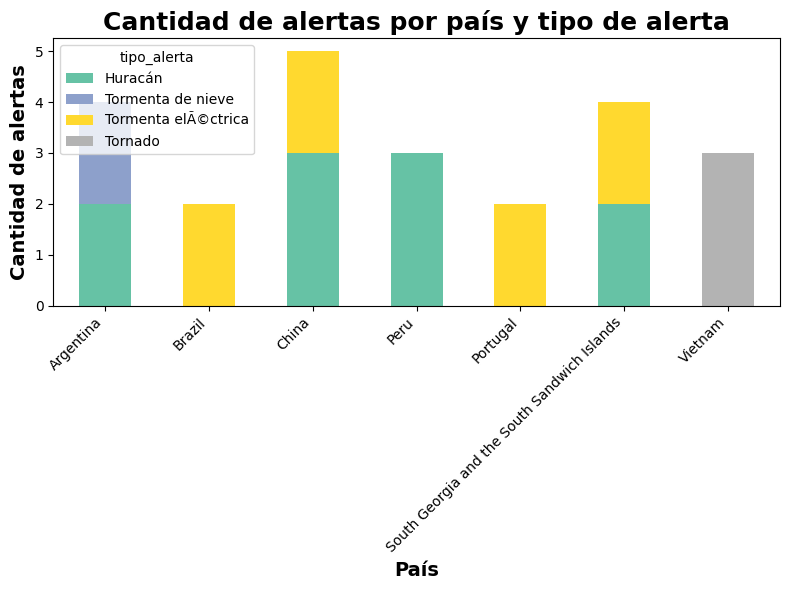

In [84]:
# Asegúrate de que los datos estén correctamente codificados
df_cma['tipo_alerta'] = df_cma['tipo_alerta'].str.replace("Ã¡", "á").replace("Ã­", "í")

# Pivotar los datos para tener las alertas por país y tipo de alerta
df_pivot = df_cma.pivot_table(index='pais', columns='tipo_alerta', values='cantidad_alertas', aggfunc='sum', fill_value=0)

# Crear el gráfico de barras apiladas
df_pivot.plot(kind='bar', stacked=True, figsize=(8, 6), colormap='Set2')

# Títulos y etiquetas
plt.title('Cantidad de alertas por país y tipo de alerta', fontsize=18, fontweight='bold')
plt.xlabel('País', fontsize=14, fontweight='bold')
plt.ylabel('Cantidad de alertas', fontsize=14, fontweight='bold')

# Rotar las etiquetas del eje X para que se vean bien
plt.xticks(rotation=45, ha='right')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

### alertas_activas

In [85]:
# Creamos la tabla externa "alertas_activas" con el esquema definido en HIVE, separado por coma.
# Se envia la particion de los datos al area de analitica (anl) definido en LOCATION al directorio en HDFS.
spark.sql(
    """
    CREATE EXTERNAL TABLE IF NOT EXISTS meteosmart.alertas_activas ( 
    	pais STRING, 
    	ciudad STRING,
        Latitud DOUBLE,
        Longitud DOUBLE,
        tipo_alerta STRING,
        nivel_alerta STRING,
        duracion STRING,
        status STRING

    ) 
    ROW FORMAT DELIMITED 
    FIELDS TERMINATED BY ',' 
    STORED AS TEXTFILE 
    LOCATION '/user/ec2-user/Obligatorio_315622_338835_208166/MeteoSmart/anl/alertas_activas';
    """
).show()

++
||
++
++



In [86]:
# Insertamos los datos del resultado de la consulta en la tabla creada mediante el esquema anterior.
spark.sql(
    """
    INSERT OVERWRITE TABLE meteosmart.alertas_activas
    
    SELECT P.pais, P.ciudad, P.Latitud, P.Longitud, A.tipo_alerta, A.nivel_alerta, E.duracion, E.status
    FROM meteosmart.eventos E
    INNER JOIN meteosmart.alertas A ON A.id_alerta_met = E.id_alerta_met
    INNER JOIN meteosmart.paises P ON P.id_pais = E.id_pais
    WHERE E.status = 'Activo' AND unix_timestamp(E.duracion, 'hh:mm:ss') > 3600
    """
).show()

++
||
++
++



In [87]:
# Observamos el contenido de la tabla de analitica creada con los datos agregados de la propia consulta.
# Utilizamos el metodo toPandas() para obtener un dataframe de pandas con una mejor visualizacion de la consulta.
alertas_activas = spark.sql(
    """
    SELECT * FROM meteosmart.alertas_activas
    """
).toPandas()

In [88]:
alertas_activas

,pais,ciudad,Latitud,Longitud,tipo_alerta,nivel_alerta,duracion,status
0,Brazil,Varjota,-4.194808,-40.476033,HuracÃ¡n,Alto,05:00:27,Activo
1,China,Lifuta,29.341703,110.085494,Tormenta elÃ©ctrica,Bajo,03:10:38,Activo
2,South Georgia and the South Sandwich Islands,Grytviken,-54.281149,-36.508738,Tormenta de nieve,Alto,02:04:30,Activo
3,South Georgia and the South Sandwich Islands,Grytviken,-54.281149,-36.508738,HuracÃ¡n,Moderado,05:35:10,Activo
4,Netherlands,Schiedam postbusnummers,51.883000,4.357700,Alerta de tsunamis,Alto,01:15:45,Activo
5,South Georgia and the South Sandwich Islands,Grytviken,-54.281149,-36.508738,Tormenta elÃ©ctrica,Extremo,03:49:23,Activo
6,Russia,Ramon,51.934757,39.322171,Alerta de tormenta tropical,Alto,04:07:59,Activo
7,Finland,Jurva,62.851154,21.735279,Granizo,Alto,05:10:18,Activo
8,Philippines,Lamak,10.121902,123.539314,HuracÃ¡n,Alto,04:44:30,Activo


In [89]:
# Creamos una copia del dataframe para poder visualizar graficamente.
df_aa = alertas_activas.copy()

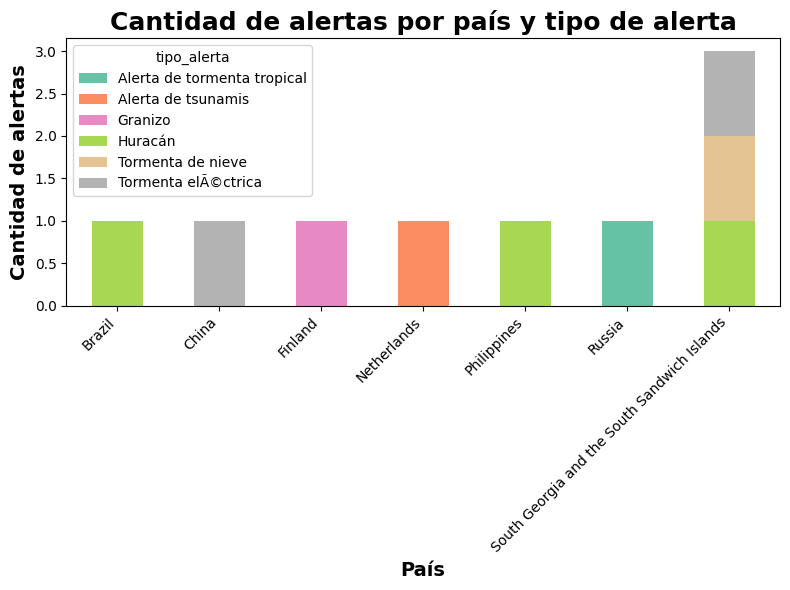

In [90]:
# Asegúrate de que los datos estén correctamente codificados
df_aa['tipo_alerta'] = df_aa['tipo_alerta'].str.replace("Ã¡", "á").replace("Ã­", "í")

# Pivotar los datos para tener las alertas por país y tipo de alerta
df_pivot = df_aa.pivot_table(index='pais', columns='tipo_alerta', values='nivel_alerta', aggfunc='count', fill_value=0)

# Crear el gráfico de barras apiladas
df_pivot.plot(kind='bar', stacked=True, figsize=(8, 6), colormap='Set2')

# Títulos y etiquetas
plt.title('Cantidad de alertas por país y tipo de alerta', fontsize=18, fontweight='bold')
plt.xlabel('País', fontsize=14, fontweight='bold')
plt.ylabel('Cantidad de alertas', fontsize=14, fontweight='bold')

# Rotar las etiquetas del eje X para que se vean bien
plt.xticks(rotation=45, ha='right')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

### max_temp_paises

In [91]:
# Creamos la tabla externa "max_temp_paises" con el esquema definido en HIVE, separado por coma.
# Se envia la particion de los datos al area de analitica (anl) definido en LOCATION al directorio en HDFS.
spark.sql(
    """
    CREATE EXTERNAL TABLE IF NOT EXISTS meteosmart.max_temp_paises ( 
    	ciudad STRING,
        pais STRING,
        fecha DATE,
        Latitud DOUBLE,
        Longitud DOUBLE,
    	temperatura_maxima FLOAT

    ) 
    ROW FORMAT DELIMITED 
    FIELDS TERMINATED BY ',' 
    STORED AS TEXTFILE 
    LOCATION '/user/ec2-user/Obligatorio_315622_338835_208166/MeteoSmart/anl/max_temp_paises';
    """
).show()

++
||
++
++



In [92]:
# Insertamos los datos del resultado de la consulta en la tabla creada mediante el esquema anterior.
spark.sql(
    """
    INSERT OVERWRITE TABLE meteosmart.max_temp_paises
    
    SELECT P.ciudad, P.pais, E.fecha, P.Latitud, P.Longitud,  MAX(E.max_temp) AS temperatura_maxima
    FROM meteosmart.eventos E
    INNER JOIN meteosmart.paises P ON E.id_pais = P.id_pais
    WHERE YEAR(E.fecha) = 2024
    GROUP BY P.ciudad, P.pais, E.fecha, P.Latitud, P.Longitud 
    ORDER BY temperatura_maxima DESC, E.fecha DESC
    LIMIT 10
    """
).show()

++
||
++
++



In [93]:
# Observamos el contenido de la tabla de analitica creada con los datos agregados de la propia consulta.
# Utilizamos el metodo toPandas() para obtener un dataframe de pandas con una mejor visualizacion de la consulta.
max_temp_paises = spark.sql(
    """
    SELECT * FROM meteosmart.max_temp_paises
    """
).toPandas()

In [94]:
max_temp_paises

,ciudad,pais,fecha,Latitud,Longitud,temperatura_maxima
0,Guaxupé,Brazil,2024-10-02,-21.305488,-46.708493,41.099998
1,Guaxupé,Brazil,2024-05-21,-21.305488,-46.708493,41.099998
2,Jianshan,China,2024-03-04,46.646350,131.158416,41.099998
3,Pepe,Indonesia,2024-03-17,-7.403915,112.771821,40.900002
4,Susoh,Indonesia,2024-08-11,3.722062,96.829740,40.799999
5,Shanhou,China,2024-02-29,23.354091,116.681972,40.799999
6,Krajan Dukuhseti,Indonesia,2024-09-20,-6.476156,111.040003,40.700001
7,Unión,Argentina,2024-09-08,-32.891640,-60.703917,40.700001
8,Flórina,Greece,2024-01-25,40.784526,21.413122,40.599998
9,Biaoxi,China,2024-10-28,28.002849,118.764957,40.500000


In [95]:
# Creamos una copia del dataframe para poder visualizar graficamente.
df_mtp = max_temp_paises.copy()

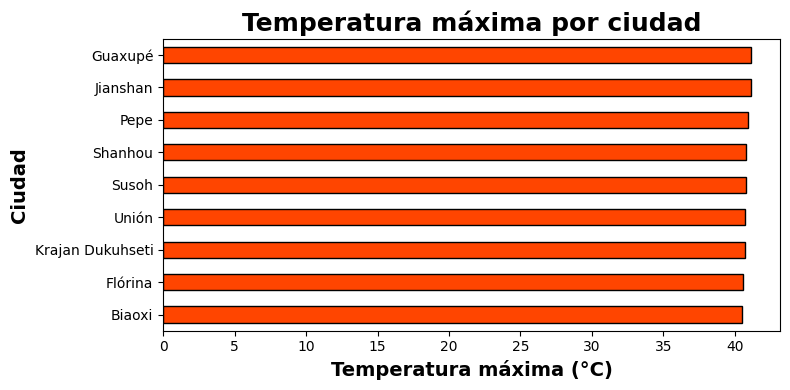

In [96]:
# Asegúrate de que la columna 'fecha' esté en formato datetime
df_mtp['fecha'] = pd.to_datetime(df_mtp['fecha'])

# Crear un gráfico de barras horizontales para la temperatura máxima por ciudad
plt.figure(figsize=(8, 4))

# Agrupar por ciudad y calcular la temperatura máxima
df_grouped = df_mtp.groupby('ciudad')['temperatura_maxima'].max().sort_values(ascending=True)

# Crear el gráfico de barras horizontales
df_grouped.plot(kind='barh', color='orangered', edgecolor='black')

# Títulos y etiquetas
plt.title('Temperatura máxima por ciudad', fontsize=18, fontweight='bold')
plt.xlabel('Temperatura máxima (°C)', fontsize=14, fontweight='bold')
plt.ylabel('Ciudad', fontsize=14, fontweight='bold')

# Ajustar el diseño
plt.tight_layout()

# Mostrar el gráfico
plt.show()

### frec_alertas

In [97]:
# Creamos la tabla externa "frec_alertas" con el esquema definido en HIVE, separado por coma.
# Se envia la particion de los datos al area de analitica (anl) definido en LOCATION al directorio en HDFS.
spark.sql(
    """
    CREATE EXTERNAL TABLE IF NOT EXISTS meteosmart.frec_alertas ( 
    	tipo_alerta STRING, 
    	frecuencia_alerta INT

    ) 
    ROW FORMAT DELIMITED 
    FIELDS TERMINATED BY ',' 
    STORED AS TEXTFILE 
    LOCATION '/user/ec2-user/Obligatorio_315622_338835_208166/MeteoSmart/anl/frec_alertas';
    """
).show()

++
||
++
++



In [98]:
# Insertamos los datos del resultado de la consulta en la tabla creada mediante el esquema anterior.
spark.sql(
    """
    INSERT OVERWRITE TABLE meteosmart.frec_alertas
    
    SELECT A.tipo_alerta, COUNT(E.id_usuario) frecuencia_alerta
    FROM meteosmart.eventos E
    INNER JOIN meteosmart.alertas A ON A.id_alerta_met = E.id_alerta_met
    GROUP BY A.tipo_alerta
    ORDER BY frecuencia_alerta DESC
    """
).show()

++
||
++
++



In [99]:
# Observamos el contenido de la tabla de analitica creada con los datos agregados de la propia consulta.
# Utilizamos el metodo toPandas() para obtener un dataframe de pandas con una mejor visualizacion de la consulta.
frec_alertas = spark.sql(
    """
    SELECT * FROM meteosmart.frec_alertas
    """
).toPandas()

In [100]:
frec_alertas

,tipo_alerta,frecuencia_alerta
0,Tormenta elÃ©ctrica,88
1,HuracÃ¡n,72
2,Tormenta de nieve,71
3,Tornado,67
4,Alerta de lluvias intensas,19
5,Alerta de nevada,17
6,Granizo,14
7,Alerta de tsunamis,13
8,InundaciÃ³n,13
9,Alerta de niebla densa,13


In [101]:
# Creamos una copia del dataframe para poder visualizar graficamente.
df_fa = frec_alertas.copy()

/tmp/ipykernel_3884/1468612607.py:20: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  ax.legend(wedges, alertas, title="Tipos de Alerta", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1),


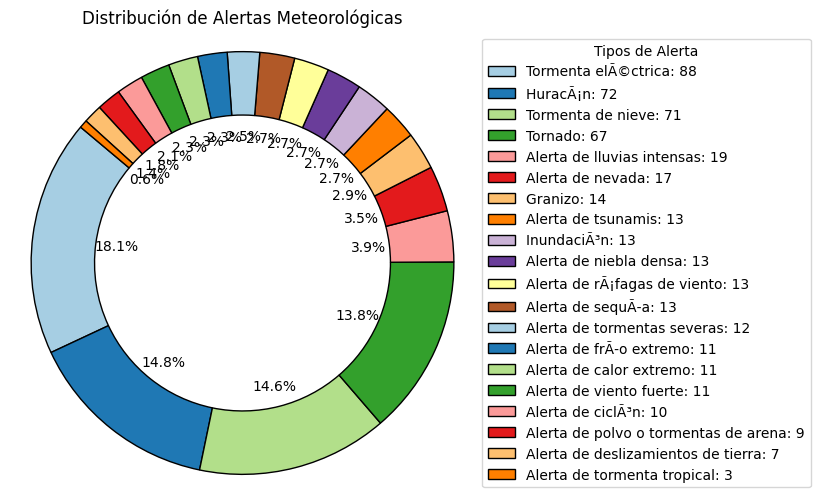

In [102]:
# Extraer los datos
alertas = df_fa['tipo_alerta']
frecuencia = df_fa['frecuencia_alerta']

# Colores del gráfico
colores = plt.cm.Paired.colors

# Crear gráfico de dona
fig, ax = plt.subplots(figsize=(6,6))

# Crear una dona con un agujero en el centro (sin etiquetas sobre el gráfico)
wedges, texts, autotexts = ax.pie(frecuencia, autopct='%1.1f%%', startangle=140, 
                                  colors=colores, wedgeprops={'edgecolor': 'black', 'width': 0.3})

# Ajustar las etiquetas
ax.set_title('Distribución de Alertas Meteorológicas')
ax.axis('equal')  # Para que el gráfico sea un círculo

# Crear un diccionario a la izquierda con las etiquetas y sus colores
ax.legend(wedges, alertas, title="Tipos de Alerta", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1),
          labels=[f"{alerta}: {frecuencia[i]}" for i, alerta in enumerate(alertas)])

# Mostrar el gráfico
plt.show()

### mejores_lugares_surf

In [103]:
# Creamos la tabla externa "mejores_lugares_surf" con el esquema definido en HIVE, separado por coma.
# Se envia la particion de los datos al area de analitica (anl) definido en LOCATION al directorio en HDFS.
spark.sql(
    """
    CREATE EXTERNAL TABLE IF NOT EXISTS meteosmart.mejores_lugares_surf ( 
    	pais STRING, 
    	ciudad STRING,
        Latitud DOUBLE,
        Longitud DOUBLE,
        zona STRING,
        estado STRING,
        altura_oleaje_marea FLOAT,
        periodo_oleaje_marea FLOAT,
        intensidad_viento INT

    ) 
    ROW FORMAT DELIMITED 
    FIELDS TERMINATED BY ',' 
    STORED AS TEXTFILE 
    LOCATION '/user/ec2-user/Obligatorio_315622_338835_208166/MeteoSmart/anl/mejores_lugares_surf';
    """
).show()

++
||
++
++



In [104]:
# Insertamos los datos del resultado de la consulta en la tabla creada mediante el esquema anterior.
spark.sql(
    """
    INSERT OVERWRITE TABLE meteosmart.mejores_lugares_surf
    
    SELECT P.pais, P.ciudad, P.Latitud, P.Longitud, P.zona, P.estado, E.altura_oleaje_marea, E.periodo_oleaje_marea, E.intensidad_viento
    FROM meteosmart.eventos E
    INNER JOIN meteosmart.paises P ON P.id_pais = E.id_pais
    WHERE E.altura_oleaje_marea > 2 AND (E.periodo_oleaje_marea BETWEEN 12 AND 15) AND intensidad_viento <= 10
    LIMIT 3
    """
).show()

++
||
++
++



In [105]:
# Observamos el contenido de la tabla de analitica creada con los datos agregados de la propia consulta.
# Utilizamos el metodo toPandas() para obtener un dataframe de pandas con una mejor visualizacion de la consulta.
mejores_lugares_surf = spark.sql(
    """
    SELECT * FROM meteosmart.mejores_lugares_surf
    """
).toPandas()

In [106]:
mejores_lugares_surf

,pais,ciudad,Latitud,Longitud,zona,estado,altura_oleaje_marea,periodo_oleaje_marea,intensidad_viento
0,Vietnam,Th? Tr?n Ngan D?a,9.571344,105.449540,Asia/Ho_Chi_Minh,None,2.8,12.5,8
1,Georgia,Bakuriani,41.750972,43.529185,Asia/Tbilisi,None,2.5,12.4,9
2,Portugal,Nossa Senhora de Machede,38.578306,-7.775687,Europe/Lisbon,Évora,2.6,14.6,9


In [107]:
# Creamos una copia del dataframe para poder visualizar graficamente.
df_mls = mejores_lugares_surf.copy()

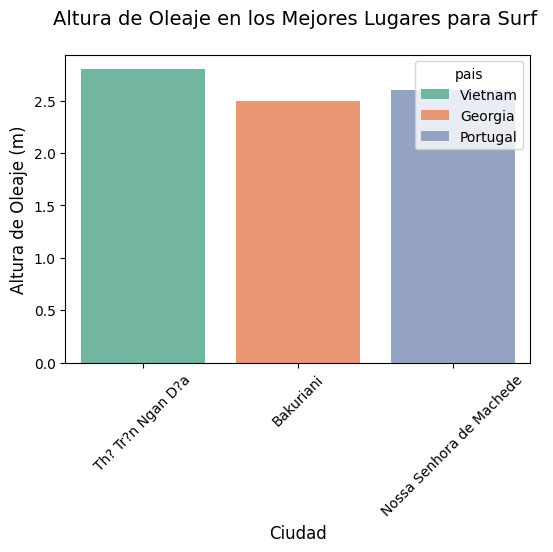

In [108]:
plt.figure(figsize=(6, 4))

# Usar seaborn para crear un gráfico de barras con diferentes colores por país
sns.barplot(x='ciudad', y='altura_oleaje_marea', hue='pais', data=df_mls, palette='Set2')

# Añadir título y etiquetas
plt.title('Altura de Oleaje en los Mejores Lugares para Surf \n', fontsize=14)
plt.xlabel('Ciudad', fontsize=12)
plt.ylabel('Altura de Oleaje (m)', fontsize=12)
plt.xticks(rotation=45)

# Mostrar gráfico
plt.show()